# Problem Setup and Math
## Problem Statement
We are solving the multi-agent optimization problem for First-Price Sealed-Bid Auctions. Each agent $i$ tries to maximize their expected utility:

$$
U_i(b_i, b_{-i}) = (v_i - b_i) \cdot \mathbb{1}(b_i > \max_{j \neq i} b_j)
$$

## The Differentiability Challenge

The indicator function $\mathbb{1}(\cdot)$ is a step function with zero gradient almost everywhere. To allow for Gradient Ascent, we approximate the winner determination using a sigmoid relaxation:

$$
P(\text{win}) \approx \sigma(\beta (b_i - m_i)) = \frac{1}{1 + e^{-\beta(b_i - m_i)}}
$$

Where:
* $m_i = \max_{j \neq i} b_j$ is the highest competing bid.
* $\beta$ is the "temperature" (higher $\beta$ = closer to step function).

Our objective is to find the optimal bidding parameter $w_i$ such that $b_i = w_i \cdot v_i$.

# Imports and Configuration

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
N_AGENTS = 2
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 2000
BETA = 50.0
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# Differentiable Auction Mechanism

In [5]:
def compute_soft_utility(agent_bids, valuations, beta=10.0):
    """
    Computes differentiable utility for N agents using Softmax/Sigmoid relaxation.
    
    Args:
        agent_bids: Tensor of shape (batch_size, n_agents)
        valuations: Tensor of shape (batch_size, n_agents)
        beta: Smoothing temperature
        
    Returns:
        utilities: Tensor of shape (batch_size, n_agents)
    """
    # Identify the highest competing bid for each agent by using duplicate bids, mask self, take max
    batch_size, n_agents = agent_bids.shape
    device = agent_bids.device
    
    utilities = []
    
    for i in range(n_agents):
        # Get agent i's bid and valuation
        b_i = agent_bids[:, i]
        v_i = valuations[:, i]
        
        # Get max bid of everyone else
        other_bids = torch.cat([agent_bids[:, :i], agent_bids[:, i+1:]], dim=1)
        max_competing_bid, _ = other_bids.max(dim=1)
        
        # Compute Soft Win Probability via Sigmoid
        # sigmoid( beta * (my_bid - highest_other_bid) )
        diff = b_i - max_competing_bid
        prob_win = torch.sigmoid(beta * diff)
        
        # Compute Expected Utility: (Value - Bid) * Prob_Win
        util = (v_i - b_i) * prob_win
        utilities.append(util)
        
    return torch.stack(utilities, dim=1)

# Agent Model

In [6]:
class LinearBidder(nn.Module):
    """
    A simple agent that learns a linear bidding strategy: b = w * v + c
    For standard auctions, we expect c -> 0 and w -> (N-1)/N.
    """
    def __init__(self, n_agents_in_game):
        super().__init__()
        # Initialize weight slightly below 1.0 (truthful bidding start)
        self.w = nn.Parameter(torch.tensor([0.9])) 
        # We can fix bias to 0 for this experiment to strictly test linear scaling
        self.b = nn.Parameter(torch.tensor([0.0]), requires_grad=False) 
        
    def forward(self, valuation):
        # Enforce bid to be non-negative and ideally <= valuation
        # Using sigmoid on w ensures multiplier is between 0 and 1
        multiplier = torch.sigmoid(self.w) 
        bid = multiplier * valuation + self.b
        return bid

# Instantiate Agents
agents = [LinearBidder(N_AGENTS) for _ in range(N_AGENTS)]
optimizers = [optim.Adam(agent.parameters(), lr=LEARNING_RATE) for agent in agents]

# Training Loop Optimization

In [7]:
history = {'loss': [], 'multipliers': []}

print("Starting training...")

for epoch in range(EPOCHS):
    # ample Valuations (Uniform [0,1])
    # Shape: (BATCH_SIZE, N_AGENTS)
    valuations = torch.rand((BATCH_SIZE, N_AGENTS))
    
    # Get Bids from all agents
    bids_list = []
    for i in range(N_AGENTS):
        bids_list.append(agents[i](valuations[:, i]))
    
    # Stack bids: (BATCH_SIZE, N_AGENTS)
    bids = torch.stack(bids_list, dim=1)
    
    # Compute Utilities
    utilities = compute_soft_utility(bids, valuations, beta=BETA)
    
    # Update Each Agent
    epoch_loss = 0
    current_multipliers = []
    
    for i in range(N_AGENTS):
        optimizer = optimizers[i]
        optimizer.zero_grad()
        
        # Loss = Negative Mean Utility
        loss = -utilities[:, i].mean()
        loss.backward(retain_graph=True) # Retain graph because bids are shared
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Log current learned multiplier (w)
        with torch.no_grad():
            current_multipliers.append(torch.sigmoid(agents[i].w).item())

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Avg Utility = {-epoch_loss/N_AGENTS:.4f}, Multipliers = {[round(m, 3) for m in current_multipliers]}")
    
    history['loss'].append(epoch_loss)
    history['multipliers'].append(current_multipliers)

print("Training complete.")

Starting training...
Epoch 0: Avg Utility = 0.0925, Multipliers = [0.709, 0.709]
Epoch 100: Avg Utility = 0.1612, Multipliers = [0.518, 0.518]
Epoch 200: Avg Utility = 0.1791, Multipliers = [0.472, 0.477]
Epoch 300: Avg Utility = 0.1673, Multipliers = [0.484, 0.487]
Epoch 400: Avg Utility = 0.1757, Multipliers = [0.488, 0.481]
Epoch 500: Avg Utility = 0.1796, Multipliers = [0.48, 0.48]
Epoch 600: Avg Utility = 0.1658, Multipliers = [0.492, 0.49]
Epoch 700: Avg Utility = 0.1698, Multipliers = [0.491, 0.496]
Epoch 800: Avg Utility = 0.1838, Multipliers = [0.474, 0.471]
Epoch 900: Avg Utility = 0.1855, Multipliers = [0.477, 0.477]
Epoch 1000: Avg Utility = 0.1751, Multipliers = [0.473, 0.475]
Epoch 1100: Avg Utility = 0.1763, Multipliers = [0.479, 0.474]
Epoch 1200: Avg Utility = 0.1755, Multipliers = [0.469, 0.475]
Epoch 1300: Avg Utility = 0.1650, Multipliers = [0.478, 0.476]
Epoch 1400: Avg Utility = 0.1749, Multipliers = [0.475, 0.471]
Epoch 1500: Avg Utility = 0.1792, Multipliers = [

# Validation and Results

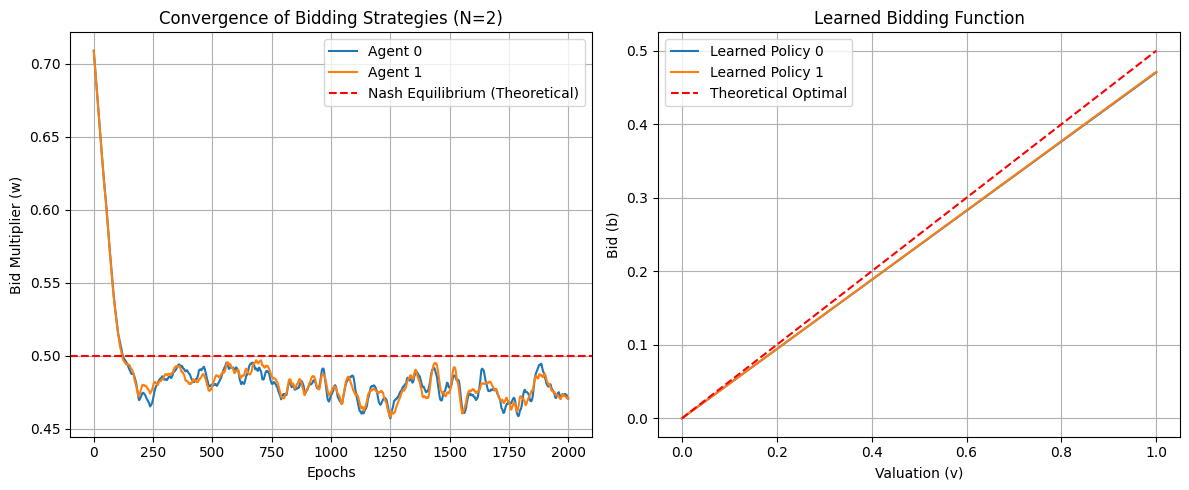

In [8]:
# Theoretical Optimal for N symmetric agents: w = (N-1)/N
# For N = 2, optimal w = 0.5
theoretical_opt = (N_AGENTS - 1) / N_AGENTS

plt.figure(figsize=(12, 5))

# Plot 1: Learning Dynamics
plt.subplot(1, 2, 1)
multipliers = np.array(history['multipliers'])
for i in range(N_AGENTS):
    plt.plot(multipliers[:, i], label=f'Agent {i}')

plt.axhline(y=theoretical_opt, color='r', linestyle='--', label='Nash Equilibrium (Theoretical)')
plt.title(f'Convergence of Bidding Strategies (N={N_AGENTS})')
plt.xlabel('Epochs')
plt.ylabel('Bid Multiplier (w)')
plt.legend()
plt.grid(True)

# Plot 2: Bid Landscape (Visualizing the learned function)
plt.subplot(1, 2, 2)
test_vals = torch.linspace(0, 1, 100)
with torch.no_grad():
    for i in range(N_AGENTS):
        test_bids = agents[i](test_vals)
        plt.plot(test_vals.numpy(), test_bids.numpy(), label=f'Learned Policy {i}')

plt.plot(test_vals.numpy(), test_vals.numpy() * theoretical_opt, 'r--', label='Theoretical Optimal')
plt.title('Learned Bidding Function')
plt.xlabel('Valuation (v)')
plt.ylabel('Bid (b)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()